<a href="https://colab.research.google.com/github/samuelccotta/sar_autoencoders/blob/main/SAR_Autoencoders_comparativos_otimizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Verificando versões instaladas no sistema

In [1]:
import tensorflow as tf
import sys
print(sys.version)
print(tf.__version__)

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
2.19.0


# Instalação das bibliotecas necessárias

In [2]:
# Instalação necessária
!pip install -q kaggle
!pip install -q scikit-image

# Importação das bibliotecas

In [3]:
import os, zipfile, cv2, time
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.losses import mse
import tensorflow.keras.backend as K
from skimage.metrics import structural_similarity as ssim
from tensorflow.image import ssim_multiscale
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from google.colab import files

# Download do dataset
>Deve-se gerar o arquivo kaggle.json no site
>https://www.kaggle.com/

In [4]:
uploaded = files.upload()

# Criar diretório e mover o kaggle.json
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(uploaded['kaggle.json'])

os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Baixar o dataset SARD 2
!kaggle datasets download -d nikolasgegenava/sard-2-search-and-rescue-dataset-extra-classes
!unzip -q sard-2-search-and-rescue-dataset-extra-classes.zip -d sard2

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nikolasgegenava/sard-2-search-and-rescue-dataset-extra-classes
License(s): MIT
100% 1.24G/1.24G [00:13<00:00, 251MB/s]
100% 1.24G/1.24G [00:13<00:00, 97.7MB/s]


# Pré-processamento carregamento das imagens

In [5]:
def carregar_imagens(pasta, tamanho=(128, 128), max_imgs=3000):
    imagens = []
    for img_nome in tqdm(os.listdir(pasta)[:max_imgs]):
        img_path = os.path.join(pasta, img_nome)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            img = cv2.resize(img, tamanho)
            img = img.astype('float32') / 255.0
            imagens.append(img)
    return np.array(imagens)

X_train = carregar_imagens('sard2/search-and-rescue-2/train/images')
X_val   = carregar_imagens('sard2/search-and-rescue-2/valid/images')
X_test  = carregar_imagens('sard2/search-and-rescue-2/test/images')

100%|██████████| 198/198 [00:02<00:00, 68.49it/s]


# Definição dos Modelos de Autoencoders

> Estudar autoencoder assimétrico UFRJ: https://www.gta.ufrj.br/ftp/gta/TechReports/GCC23.pdf

**Modelo Autoencoder Convencional Convulucional**

In [6]:
# 1) Autoencoder Convencional
def criar_autoencoder(input_shape=(128,128,3)):
    #Encoder
    inp = Input(shape=input_shape, name='conv_input')
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D(2, padding='same')(x) # Dimensão: 64x64
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x) # Dimensão: 32x32

    #Decoder Antigo
    #x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    #x = layers.UpSampling2D(2)(x)
    #x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    #x = layers.UpSampling2D(2)(x)
    #out = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    # Decoder (usando Conv2DTranspose)
    x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(16, (3, 3), activation='relu', strides=(2, 2), padding='same')(x) # UpSample para 64x64
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x) # UpSample para 128x128
    out = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoenc = Model(inp, out, name='autoencoder_conv')
    autoenc.compile(optimizer='adam', loss='mse')
    return autoenc

**Modelo Autoencoder Variacional**

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Entrada de dados
            x, _ = data

            # Executa o modelo
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)

            # Calcula a perda de reconstrução
            reconstruction_loss = tf.reduce_mean(
               mse(x, reconstruction)
            )
            reconstruction_loss *= 128 * 128

            # Calcula a perda KL
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        # Calcula gradientes e otimiza
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Atualiza métricas
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

def criar_vae(input_shape=(128,128,3), latent_dim=64):
    # Encoder
    inputs = layers.Input(shape=input_shape, name='encoder_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    flatten = layers.Flatten()(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(flatten)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(flatten)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32 * 32 * 16, activation='relu')(latent_inputs)
    x = layers.Reshape((32, 32, 16))(x)
    x = layers.Conv2DTranspose(16, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')

    # Instancia o modelo VAE
    vae = VAE(encoder, decoder)
    vae.compile(optimizer='adam', loss=mse)
    return vae

**Modelo Autoencoeder Redundância**

In [8]:
def criar_autoencoder_redundancia(input_shape=(128,128,3)):
    input_img = Input(shape=(128, 128, 3), name='pen_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x) # 64x64
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded_conv = layers.MaxPooling2D((2, 2), padding='same')(x) # 32x32

    # Camada Latente com L1
    encoded_flat = layers.Flatten()(encoded_conv)
    latent = layers.Dense(256, activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5))(encoded_flat)

    # Decoder (usando Conv2DTranspose)
    x = layers.Dense(32 * 32 * 16, activation='relu')(latent)
    x = layers.Reshape((32, 32, 16))(x)
    x = layers.Conv2DTranspose(16, (3, 3), activation='relu', strides=(2, 2), padding='same')(x) # UpSample para 64x64
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x) # UpSample para 128x128
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss=mse)
    return autoencoder

# Treinamento e avaliação

Adicionado O EarlyStopping é um callback que interrompe o treinamento quando a métrica monitorada (no caso, a val_loss) para de melhorar. Isso impede que o modelo continue treinando e comece a "memorizar" os dados de treinamento (overfitting).


Perda dos modelos Convencional e Redundância: A perda é simplesmente o Erro Médio Quadrático (MSE). Ela mede a diferença pixel a pixel entre a imagem de entrada e a imagem reconstruída. O objetivo é que o modelo aprenda a comprimir os dados da forma mais eficiente possível para que a reconstrução seja a mais fiel possível.

Perda do modelo Variacional: A perda total é composta por dois termos:

Perda de Reconstrução: É o mesmo MSE dos outros modelos. Ele mede a fidelidade da reconstrução.

Perda de Regularização (KL Loss): Esta perda adicional penaliza o modelo por se desviar de uma distribuição normal. O VAE não apenas reconstrói a imagem, mas também aprende uma distribuição estatística do código latente. O KL Loss garante que o espaço latente seja bem-organizado, o que permite que você gere novas imagens realistas com o decodificador.

Por Que Eles São Comparáveis (e Por Que Não)
Eles são comparáveis porque todos os modelos estão sendo treinados com o objetivo de minimizar a perda de reconstrução. Ao usar a função treinar_e_avaliar para gerar as métricas PSNR, SSIM e MS-SSIM, você está de fato comparando o resultado final da reconstrução de todos os modelos.

No entanto, é importante lembrar que a perda total (total_loss) do VAE não é diretamente comparável à perda total dos outros modelos, pois ela inclui o termo de regularização.

Onde a Comparação é Válida
Você pode e deve comparar os resultados das métricas de qualidade de imagem (PSNR, SSIM, MS-SSIM) que você coleta no final da função treinar_e_avaliar. Essas métricas avaliam a fidelidade da reconstrução e permitem uma comparação direta do desempenho final.

O teste de Kruskal-Wallis, que está no seu código, é a ferramenta estatística correta para comparar essas métricas entre os modelos e determinar se há uma diferença estatisticamente significativa entre eles.

Função para exibir histórico de treinamento dos modelos

In [9]:
def plotar_historico(history, nome_modelo):
    """
    Plota o histórico de treinamento para 'loss' e a perda de validação apropriada,
    usando o nome do modelo para o título.
    """
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    # Verifica qual métrica de validação usar
    if nome_modelo == 'Variacional':
        val_metric = history.history['val_total_loss']
        val_label = 'Perda de Validação Total'
    else:
        val_metric = history.history['val_loss']
        val_label = 'Perda de Validação'

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'b', label='Perda de Treinamento')
    plt.plot(epochs, val_metric, 'r', label=val_label)
    plt.title(f'Perda de Treinamento e Validação - {nome_modelo}')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def treinar_e_avaliar(modelo, nome):
    if nome == 'Variacional':
        monitor = 'val_total_loss'
        mode = 'min'
    else:
        monitor = 'val_loss'
        mode = 'min'
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    patience=10, #para se não diminuir por 10 épocas seguidas
    restore_best_weights=True, #grava os pesos da melhor época
    mode = 'min'
)
    history = modelo.fit(X_train, X_train, epochs=800, batch_size=32, validation_data=(X_val, X_val), verbose=0, callbacks=[early_stopping])

    plotar_historico(history, nome)

    # Salva o modelo treinado em formato Keras
    modelo.save(f'{nome}.keras')

    psnr_total, ssim_total, ms_ssim_total, tempo_total = 0, 0, 0, 0
    for i in range(50):
        entrada = np.expand_dims(X_test[i], axis=0)
        inicio = time.time()
        saida = modelo.predict(entrada, verbose=0)
        fim = time.time()
        tempo_total += fim - inicio
        psnr_total += tf.image.psnr(entrada, saida, max_val=1.0).numpy()[0]
        ssim_total += ssim(entrada[0], saida[0], data_range=1.0, channel_axis=2)
        ms_ssim_total += tf.image.ssim_multiscale(
            entrada, saida,
            max_val=1.0,
            filter_size=3
        ).numpy()[0]
    return psnr_total/50, ssim_total/50, ms_ssim_total/50, tempo_total/50

modelos = {
    'Convencional': criar_autoencoder(),
    'Variacional': criar_vae(),
    'Redundância': criar_autoencoder_redundancia()
}

resultados = {}
for nome, modelo in modelos.items():
    print(f'Treinando {nome}...')
    resultados[nome] = treinar_e_avaliar(modelo, nome)


Treinando Convencional...


# Análise de resultados
>Para a avaliação da qualidade das imagens reconstruídas, foram utilizadas três métricas amplamente reconhecidas na literatura: o Peak Signal-to-Noise Ratio (PSNR), o Structural Similarity Index (SSIM) e o Multi-Scale Structural Similarity Index (MS-SSIM). O PSNR é uma métrica tradicional baseada no erro quadrático médio (MSE), amplamente utilizada para quantificar a fidelidade de uma imagem reconstruída em relação à sua versão original. Convenções na comunidade de processamento de imagens indicam que valores de PSNR acima de 30 dB são geralmente considerados uma alta qualidade visual para o olho humano, enquanto valores acima de 40 dB representam uma excelente fidelidade. Em contrapartida, o SSIM [Wang et al., 2004] e o MS-SSIM [Wang et al., 2003] são métricas que melhor correlacionam com a percepção humana da qualidade, por avaliarem a estrutura, luminância e contraste das imagens





Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image Quality Assessment: From Error Visibility to Structural Similarity. IEEE Transactions on Image Processing, 13(4), 600–612. https://doi.org/10.1109/TIP.2003.819128

Wang, Z., Simoncelli, E. P., & Bovik, A. C. (2003). Multiscale structural similarity for image quality assessment. In The Thirty-Seventh Asilomar Conference on Signals, Systems and Computers, 2003 (Vol. 2, pp. 1398–1402). IEEE. https://doi.org/10.1109/ACSSC.2003.1294653


---



PSNR (Peak Signal-to-Noise Ratio)
>O PSNR é uma métrica de fidelidade que compara o pixel a pixel da imagem original com a imagem reconstruída. Um valor mais alto indica melhor qualidade.

>Valores aceitáveis:

>*   **Acima de 30 dB:** Geralmente considerado uma boa qualidade de reconstrução para muitas aplicações. Imagens com PSNR acima de 30 dB são frequentemente visualmente indistinguíveis da original para o olho humano.
*   **Acima de 40 dB:** É uma excelente qualidade. Imagens com PSNR acima de 40 dB são consideradas de altíssima fidelidade.
*   **20-25 dB:** É considerado uma qualidade de média a baixa. Pode haver artefatos visíveis de compressão.


SSIM (Structural Similarity Index)
>O SSIM é uma métrica que considera a luminância, o contraste e a estrutura da imagem. Seu valor varia de -1 a 1, onde 1 indica uma similaridade perfeita.

>Valores aceitáveis:

>*   ***0.95 - 1.0:*** Considerado excelente. A imagem reconstruída é praticamente idêntica à original.
*  **0.85 - 0.95:** Boa qualidade. A maioria das pessoas não notaria a diferença.
*  **0.7 - 0.85:** Qualidade aceitável, mas com algumas diferenças perceptíveis

MS-SSIM (Multi-Scale Structural Similarity Index)
>O MS-SSIM é uma extensão do SSIM que avalia a similaridade em várias escalas de imagem, o que geralmente se alinha ainda melhor com a percepção humana. Seu valor também varia de -1 a 1.

>Valores aceitáveis:

>A mesma faixa de valores do SSIM se aplica, mas o MS-SSIM é frequentemente preferido para avaliar o desempenho geral da reconstrução. Um valor acima de 0.9 é considerado de alta qualidade


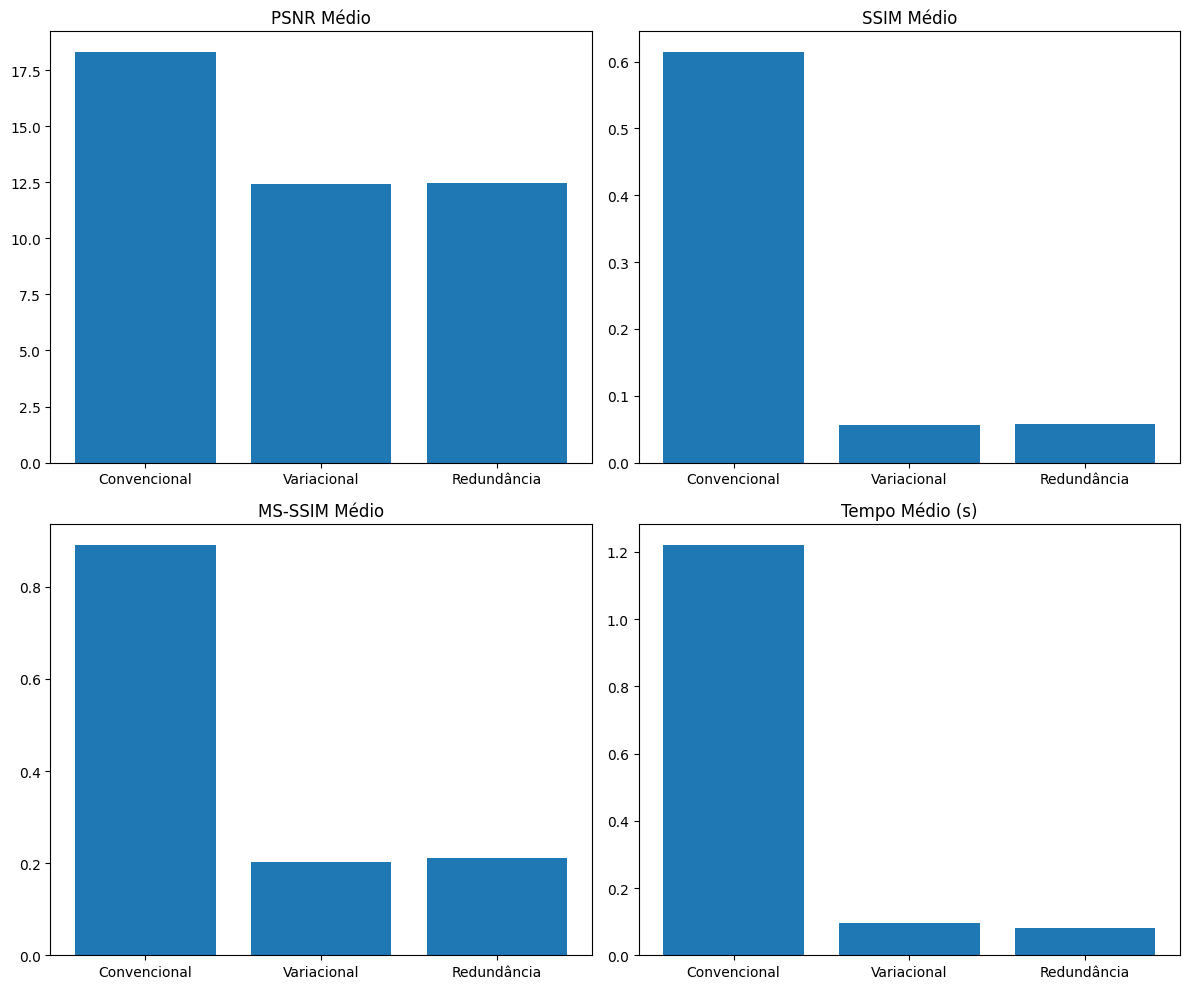

In [ ]:
labels       = list(resultados.keys())
psnr_vals    = [resultados[n][0] for n in labels]
ssim_vals    = [resultados[n][1] for n in labels]
ms_ssim_vals = [resultados[n][2] for n in labels]
tempo_vals   = [resultados[n][3] for n in labels]

# Cria um grid 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=False)

# Desenrola os eixos em uma lista para indexar facilmente
axs = axes.flatten()

# Plota cada métrica
axs[0].bar(labels, psnr_vals)
axs[0].set_title('PSNR Médio')

axs[1].bar(labels, ssim_vals)
axs[1].set_title('SSIM Médio')

axs[2].bar(labels, ms_ssim_vals)
axs[2].set_title('MS-SSIM Médio')

axs[3].bar(labels, tempo_vals)
axs[3].set_title('Tempo Médio (s)')

plt.tight_layout()
plt.show()


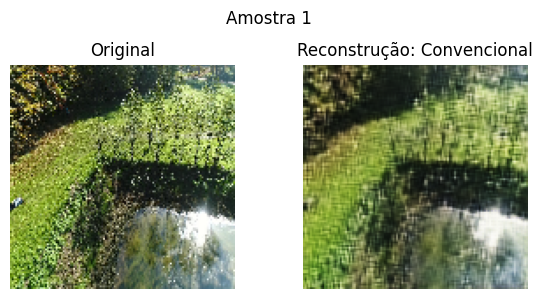

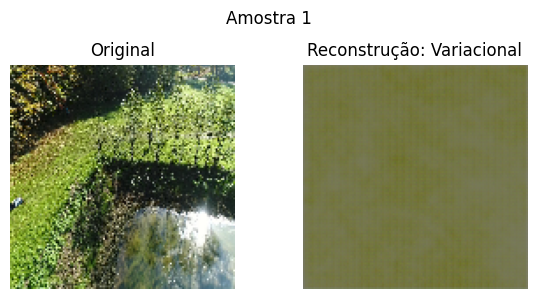

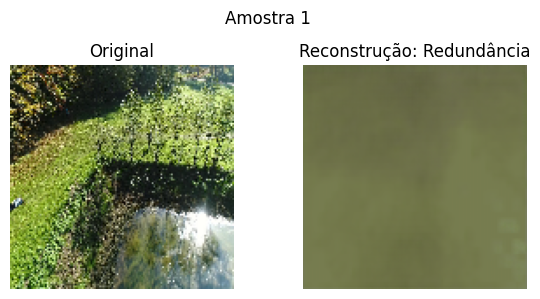

In [ ]:
def mostrar_reconstrucao(idx):
    orig = X_test[idx]
    entrada = orig[np.newaxis]

    for nome, modelo in modelos.items():
        recon = modelo.predict(entrada, verbose=0)[0]

        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.imshow(orig)
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(recon)
        plt.title(f'Reconstrução: {nome}')
        plt.axis('off')

        plt.suptitle(f'Amostra {idx}')
        plt.tight_layout()
        plt.show()

# Exemplo de uso
mostrar_reconstrucao(1)


In [ ]:
# 1) Função auxiliar que retorna as listas de métricas para um modelo
def coletar_metricas(modelo, n_amostras=50):
    psnr_list    = []
    ssim_list    = []
    ms_ssim_list = []

    # já treinou antes, mas podemos retreinar rápido para alinhar com o split
    modelo.fit(
        X_train, X_train,
        epochs=5, batch_size=32,
        validation_data=(X_val, X_val),
        verbose=0
    )

    for i in range(n_amostras):
        entrada = np.expand_dims(X_test[i], axis=0)
        saida   = modelo.predict(entrada, verbose=0)

        # acumula cada valor
        psnr_list.append(
            tf.image.psnr(entrada, saida, max_val=1.0).numpy()[0]
        )
        ssim_list.append(
            ssim(entrada[0], saida[0], data_range=1.0, channel_axis=2)
        )
        ms_ssim_list.append(
            tf.image.ssim_multiscale(
                entrada, saida,
                max_val=1.0,
                filter_size=3
            ).numpy()[0]
        )

    return psnr_list, ssim_list, ms_ssim_list

# 2) Coleta as métricas para cada modelo
psnr_conv, ssim_conv, ms_ssim_conv = coletar_metricas(modelos['Convencional'])
psnr_var,  ssim_var,  ms_ssim_var  = coletar_metricas(modelos['Variacional'])
psnr_red,  ssim_red,  ms_ssim_red  = coletar_metricas(modelos['Redundância'])

# 3) Teste de Kruskal-Wallis em cada métrica
stat_psnr, p_psnr   = kruskal(psnr_conv, psnr_var, psnr_red)
stat_ssim, p_ssim   = kruskal(ssim_conv, ssim_var, ssim_red)
stat_msss, p_msss   = kruskal(ms_ssim_conv, ms_ssim_var, ms_ssim_red)

print("Kruskal-Wallis Results:")
print(f"  PSNR   → H = {stat_psnr:.3f}, p = {p_psnr:.4f}")
print(f"  SSIM   → H = {stat_ssim:.3f}, p = {p_ssim:.4f}")
print(f"  MS-SSIM→ H = {stat_msss:.3f}, p = {p_msss:.4f}")

Kruskal-Wallis Results:
  PSNR   → H = 119.167, p = 0.0000
  SSIM   → H = 102.208, p = 0.0000
  MS-SSIM→ H = 109.253, p = 0.0000


Conversão do modelo para TensorflowLite

In [ ]:
# Carrega o modelo Keras treinado
model = tf.keras.models.load_model('caminho/para/seu/modelo.keras')

# Converte o modelo para o formato TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Salva o modelo convertido
with open('modelo_otimizado.tflite', 'wb') as f:
    f.write(tflite_model)

Inferência na borda

In [ ]:
# Carrega o modelo TFLite
interpreter = tf.lite.Interpreter(model_path="modelo_otimizado.tflite")
interpreter.allocate_tensors()

# Pega os detalhes dos tensores de entrada e saída
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Carrega e preprocessa uma nova imagem (simulação)
new_image = ... # Carregar e processar a imagem aqui
new_image = np.expand_dims(new_image, axis=0).astype(np.float32)

# Copia a nova imagem para o tensor de entrada
interpreter.set_tensor(input_details[0]['index'], new_image)

# Executa a inferência
interpreter.invoke()

# Obtém o resultado
output_data = interpreter.get_tensor(output_details[0]['index'])
reconstructed_image = output_data[0]